In [1]:
%load_ext autoreload
%autoreload 2

import sys
import os
import time

import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

sys.path.append(os.path.join(os.environ['REPO_DIR'], 'utilities'))
from utilities2015 import *
from registration_utilities import *
from annotation_utilities import *
from metadata import *
from data_manager import *

/usr/local/lib/python2.7/dist-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


Setting environment for AWS compute node


No vtk


In [2]:
stack_fixed = 'MD589'
# stack_moving = 'atlas'
stack_moving = 'MD594'

In [3]:
detector_id = 1
warp_setting = 16

In [4]:
warp_properties = registration_settings.loc[warp_setting]
print warp_properties

upstream_warp_setting = warp_properties['upstream_warp_id']
if upstream_warp_setting == 'None':
    upstream_warp_setting = None
transform_type = warp_properties['transform_type']
terminate_thresh = warp_properties['terminate_thresh']
grad_computation_sample_number = warp_properties['grad_computation_sample_number']
grid_search_sample_number = warp_properties['grid_search_sample_number']
std_tx_um = warp_properties['std_tx_um']
std_ty_um = warp_properties['std_ty_um']
std_tz_um = warp_properties['std_tz_um']
std_tx = std_tx_um/(XY_PIXEL_DISTANCE_LOSSLESS*32)
std_ty = std_ty_um/(XY_PIXEL_DISTANCE_LOSSLESS*32)
std_tz = std_tz_um/(XY_PIXEL_DISTANCE_LOSSLESS*32)
std_theta_xy = np.deg2rad(warp_properties['std_theta_xy_degree'])
print std_tx, std_ty, std_tz, std_theta_xy

try:
    surround_weight = float(warp_properties['surround_weight'])
    include_surround = surround_weight != 0 and not np.isnan(surround_weight)
except:
    surround_weight = str(warp_properties['surround_weight'])
    # Setting surround_weight as inverse is very important. Using -1 often gives false peaks.
    include_surround = True

upstream_warp_id                     None
transform_type                     affine
terminate_thresh                    1e-05
grad_computation_sample_number     100000
grid_search_sample_number            1000
std_tx_um                            2000
std_ty_um                            2000
std_tz_um                            2000
std_theta_xy_degree                    30
surround_weight                   inverse
regularization_weight                 NaN
comment                               NaN
Name: 16, dtype: object
135.869565217 135.869565217 135.869565217 0.523598775598


In [5]:
MAX_ITER_NUM = 1000
HISTORY_LEN = 20
MAX_GRID_SEARCH_ITER_NUM = 30

lr1 = 10
lr2 = 0.1

In [6]:
volume_moving, structure_to_label_moving, label_to_structure_moving = \
DataManager.load_original_volume_all_known_structures(stack=stack_moving, detector_id=detector_id, prep_id=2,
                                                   sided=False, volume_type='score')

print volume_moving[1].shape

File does not exist: /shared/CSHL_volumes/MD594/MD594_down32_annotationVolume/MD594_down32_annotationVolume_nameToLabel.txt
Prior structure/index map not found. Generating a new one.


rm -rf "/shared/CSHL_volumes/MD594/MD594_prep2_detector1_down32_scoreVolume/score_volumes/MD594_prep2_detector1_down32_scoreVolume_outerContour.bp" && mkdir -p "/shared/CSHL_volumes/MD594/MD594_prep2_detector1_down32_scoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/MD594/MD594_prep2_detector1_down32_scoreVolume/score_volumes/MD594_prep2_detector1_down32_scoreVolume_outerContour.bp" "/shared/CSHL_volumes/MD594/MD594_prep2_detector1_down32_scoreVolume/score_volumes/MD594_prep2_detector1_down32_scoreVolume_outerContour.bp"


File does not exist: /shared/CSHL_volumes/MD594/MD594_prep2_detector1_down32_scoreVolume/score_volumes/MD594_prep2_detector1_down32_scoreVolume_outerContour.bp
Score volume for outerContour does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/MD594/MD594_prep2_detector1_down32_scoreVolume/score_volumes/MD594_prep2_detector1_down32_scoreVolume_outerContour.bp'


rm -rf "/shared/CSHL_volumes/MD594/MD594_prep2_detector1_down32_scoreVolume/score_volumes/MD594_prep2_detector1_down32_scoreVolume_sp5.bp" && mkdir -p "/shared/CSHL_volumes/MD594/MD594_prep2_detector1_down32_scoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/MD594/MD594_prep2_detector1_down32_scoreVolume/score_volumes/MD594_prep2_detector1_down32_scoreVolume_sp5.bp" "/shared/CSHL_volumes/MD594/MD594_prep2_detector1_down32_scoreVolume/score_volumes/MD594_prep2_detector1_down32_scoreVolume_sp5.bp"
(347, 538, 373)


File does not exist: /shared/CSHL_volumes/MD594/MD594_prep2_detector1_down32_scoreVolume/score_volumes/MD594_prep2_detector1_down32_scoreVolume_sp5.bp
Score volume for sp5 does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/MD594/MD594_prep2_detector1_down32_scoreVolume/score_volumes/MD594_prep2_detector1_down32_scoreVolume_sp5.bp'
Volume shape: (347, 538, 373)


In [7]:
volume_fixed, structure_to_label_fixed, label_to_structure_fixed = \
DataManager.load_original_volume_all_known_structures(stack=stack_fixed, detector_id=detector_id, prep_id=2,
                                                   sided=False, volume_type='score')

print volume_fixed[1].shape

File does not exist: /shared/CSHL_volumes/MD589/MD589_down32_annotationVolume/MD589_down32_annotationVolume_nameToLabel.txt
Prior structure/index map not found. Generating a new one.


rm -rf "/shared/CSHL_volumes/MD589/MD589_prep2_detector1_down32_scoreVolume/score_volumes/MD589_prep2_detector1_down32_scoreVolume_outerContour.bp" && mkdir -p "/shared/CSHL_volumes/MD589/MD589_prep2_detector1_down32_scoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/MD589/MD589_prep2_detector1_down32_scoreVolume/score_volumes/MD589_prep2_detector1_down32_scoreVolume_outerContour.bp" "/shared/CSHL_volumes/MD589/MD589_prep2_detector1_down32_scoreVolume/score_volumes/MD589_prep2_detector1_down32_scoreVolume_outerContour.bp"


File does not exist: /shared/CSHL_volumes/MD589/MD589_prep2_detector1_down32_scoreVolume/score_volumes/MD589_prep2_detector1_down32_scoreVolume_outerContour.bp
Score volume for outerContour does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/MD589/MD589_prep2_detector1_down32_scoreVolume/score_volumes/MD589_prep2_detector1_down32_scoreVolume_outerContour.bp'


rm -rf "/shared/CSHL_volumes/MD589/MD589_prep2_detector1_down32_scoreVolume/score_volumes/MD589_prep2_detector1_down32_scoreVolume_sp5.bp" && mkdir -p "/shared/CSHL_volumes/MD589/MD589_prep2_detector1_down32_scoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/MD589/MD589_prep2_detector1_down32_scoreVolume/score_volumes/MD589_prep2_detector1_down32_scoreVolume_sp5.bp" "/shared/CSHL_volumes/MD589/MD589_prep2_detector1_down32_scoreVolume/score_volumes/MD589_prep2_detector1_down32_scoreVolume_sp5.bp"
(373, 485, 381)


File does not exist: /shared/CSHL_volumes/MD589/MD589_prep2_detector1_down32_scoreVolume/score_volumes/MD589_prep2_detector1_down32_scoreVolume_sp5.bp
Score volume for sp5 does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/MD589/MD589_prep2_detector1_down32_scoreVolume/score_volumes/MD589_prep2_detector1_down32_scoreVolume_sp5.bp'
Volume shape: (373, 485, 381)


In [8]:
# structure_subset = ['7N_L', '7N_R', '12N', '5N_L', 'Pn_R', 'SNR_L', 'VLL_R', '7n_L', 'Tz_R', 'VCA_L', 'VCP_R']
# structure_subset = ['7N_L', '7N_R', '12N', '5N_L','5N_R', 
#                     'VLL_L', 'VLL_R', '7n_L', '7n_R', 'Tz_L', 'Tz_R', 
#                     'VCA_L', 'VCA_R', 'VCP_L', 'VCP_R']
structure_subset = ['7N_L', '7N_R', '12N', '5N_L','5N_R','Pn_L', 'Pn_R', 'SNR_L', 'SNR_R', 
                    'VLL_L', 'VLL_R', '7n_L', '7n_R', 'Tz_L', 'Tz_R', 
                    'VCA_L', 'VCA_R', 'VCP_L', 'VCP_R',
                   'Sp5C_L', 'Sp5C_R']

In [9]:
structure_subset = set([convert_to_original_name(name_s) for name_s in structure_subset])

In [10]:
label_mapping_m2f = {label_m: structure_to_label_fixed[convert_to_original_name(name_m)] 
                     for label_m, name_m in label_to_structure_moving.iteritems()
                     if name_m in structure_subset}

# Computer registration

In [11]:
aligner = Aligner4(volume_fixed, volume_moving, labelIndexMap_m2f=label_mapping_m2f)

Label weights not set, default to 1 for all structures.
Regularization weights not set, default to 0.


In [12]:
aligner.set_centroid(centroid_m='volume_centroid', centroid_f='volume_centroid')
# aligner.set_centroid(centroid_m='structure_centroid', centroid_f='centroid_m', indices_m=[name_to_label_moving['SNR_R']])

m: [ 269.   173.5  186.5] f: [ 242.5  186.5  190.5]


In [13]:
grid_search_T, grid_search_score = aligner.do_grid_search(grid_search_iteration_number=MAX_GRID_SEARCH_ITER_NUM, 
                       grid_search_sample_number=5,
                      std_tx=std_tx, std_ty=std_ty, std_tz=std_tz, std_theta_xy=0,
                       grid_search_eta=3.)

sigma_tx: 135.87 (voxel), sigma_ty: 135.87, sigma_tz: 135.87, sigma_theta_xy: 0.00 (deg), n:5
grid search: 441.960994 seconds
tx_best: 0.00 (voxel), ty_best: 0.00, tz_best: 0.00, theta_xy_best: 0.00 (deg), score=22.440757
New best: -inf 22.440757
sigma_tx: 97.35 (voxel), sigma_ty: 97.35, sigma_tz: 97.35, sigma_theta_xy: 0.00 (deg), n:5
grid search: 456.769488 seconds
tx_best: 0.00 (voxel), ty_best: 0.00, tz_best: 0.00, theta_xy_best: 0.00 (deg), score=22.440757
sigma_tx: 69.76 (voxel), sigma_ty: 69.76, sigma_tz: 69.76, sigma_theta_xy: 0.00 (deg), n:5
grid search: 468.035308 seconds
tx_best: 0.00 (voxel), ty_best: 34.88, tz_best: 0.00, theta_xy_best: 0.00 (deg), score=22.627167
New best: 22.440757 22.627167
sigma_tx: 49.98 (voxel), sigma_ty: 49.98, sigma_tz: 49.98, sigma_theta_xy: 0.00 (deg), n:5
grid search: 476.222642 seconds
tx_best: 24.99 (voxel), ty_best: 9.89, tz_best: 0.00, theta_xy_best: 0.00 (deg), score=23.039327
New best: 22.627167 23.039327
sigma_tx: 35.81 (voxel), sigma_ty:

In [15]:
gradient_filepath_map_f = \
{ind_f: DataManager.get_volume_gradient_filepath_template(\
                                                          stack=stack_fixed, 
                                                          structure=label_to_structure_fixed[ind_f],
                                                          detector_id=detector_id, 
                                                         prep_id=2)
 for ind_m, ind_f in label_mapping_m2f.iteritems()}

In [16]:
aligner.load_gradient(gradient_filepath_map_f=gradient_filepath_map_f)

set([2, 5, 7, 8, 16, 21, 22, 25, 26, 27, 28])


load gradient 2: 7.677818 seconds
load gradient 5: 7.259543 seconds
load gradient 7: 8.146825 seconds
load gradient 8: 10.223550 seconds
load gradient 16: 7.577035 seconds


rm -rf "/shared/CSHL_volumes/MD589/MD589_prep2_detector1_down32_scoreVolume/score_volume_gradients/MD589_prep2_detector1_down32_scoreVolume_Sp5C_gx.bp" && mkdir -p "/shared/CSHL_volumes/MD589/MD589_prep2_detector1_down32_scoreVolume/score_volume_gradients"


load gradient 21: 8.124391 seconds
Execution failed: [Errno 12] Cannot allocate memory


OSError: [Errno 12] Cannot allocate memory

In [ ]:
# Tuning learning rate:
# lr1=10., if lucky converges much faster than lr1=1., but sometimes stuck in local maxima
# If lr1=1., grad_computation_sample_number=1e5 is sufficient.

trial_num = 5

T_all_trials = []
scores_all_trials = []
traj_all_trials = []

for _ in range(trial_num):

    try:
        T, scores = aligner.optimize(tf_type=transform_type, 
                                     max_iter_num=MAX_ITER_NUM,
                                     history_len=HISTORY_LEN, 
                                     terminate_thresh=terminate_thresh,
                                     grad_computation_sample_number=grad_computation_sample_number,
                                     lr1=lr1., lr2=lr2,
                                    init_T=grid_search_T)
        T_all_trials.append(T)
        scores_all_trials.append(scores)
        traj_all_trials.append(aligner.Ts)
        
    except Exception as e:
        sys.stderr.write('%s\n' % e)

In [49]:
# largely the same optimization path regardless of the starting condition

# For rigid, 
# grad_computation_sample_number = 1e5 is desired
# grid_search_iteration_number and grid_search_sample_number seem to be unimportant as well, set to 100
# lr1=10, lr2=.1 is best

# For affine, 
# lr2 = .001 is too slow; 0.1 rises faster than 0.01
# lr1 does not matter
# plateus around iteration 100, but keep rising afterwards.
# grad_computation_sample_number does not make a difference

T, scores = aligner.optimize(type='rigid', max_iter_num=1000, history_len=50, terminate_thresh=1e-3,
#                              indices_m=[name_to_label_fixed['SNR_L']],
                             indices_m=None,
                            grid_search_iteration_number=10,
                             grid_search_sample_number=100,
                             grad_computation_sample_number=1e5,
                             lr1=10., lr2=.1)
#                              init_T=[1,0,0,-10,0,1,0,0,0,0,1,0])

grid search: 17.520268 seconds
0.000000 1.351715
grid search: 11.774065 seconds
1.351715 1.492279
grid search: 10.170933 seconds
1.492279 1.540752
grid search: 6.469839 seconds
grid search: 4.754696 seconds
grid search: 3.480365 seconds
grid search: 3.351640 seconds
1.540752 1.550932
grid search: 2.056367 seconds
grid search: 1.839708 seconds
grid search: 1.753865 seconds
iteration 0
score: 1.550932
iteration 1
score: 1.470551
iteration 2
score: 1.618694
iteration 3
score: 1.788253
iteration 4
score: 1.950551
iteration 5
score: 1.810205
iteration 6
score: 1.823166
iteration 7
score: 1.952002
iteration 8
score: 1.927933
iteration 9
score: 1.900115
iteration 10
score: 1.933444
iteration 11
score: 1.938931
iteration 12
score: 1.955468
iteration 13
score: 1.907404
iteration 14
score: 1.960820
iteration 15
score: 1.876675
iteration 16
score: 1.934190
iteration 17
score: 1.983954
iteration 18
score: 1.933740
iteration 19
score: 1.944802
iteration 20
score: 1.959671
iteration 21
score: 1.9426

KeyboardInterrupt: 

[[  0.99182345  -0.11135864   0.06233383  21.35915876]
 [  0.11722661   0.98804583  -0.10011678   4.7536431 ]
 [ -0.05043981   0.10660535   0.99302121 -19.05057891]]
1.99604 1.984103


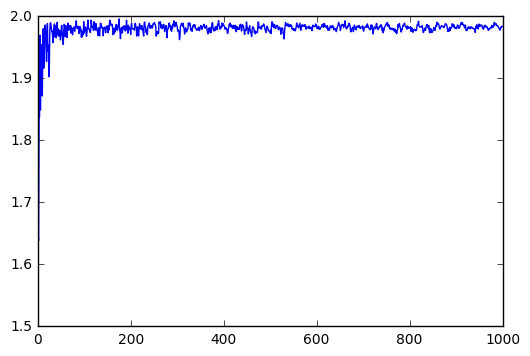

In [50]:
print T.reshape((3,4))
plt.plot(scores);
print max(scores), scores[-1]

In [46]:
atlasAlignParams_dir = create_if_not_exists(atlasAlignParams_rootdir + '/%(stack_moving)s_to_%(stack_fixed)s' % \
                     {'stack_moving': stack_moving, 'stack_fixed': stack_fixed})

In [47]:
with open(atlasAlignParams_dir + '/%(stack_moving)s_down32_scoreVolume_to_%(stack_fixed)s_down32_scoreVolume_parameters.txt' % \
          {'stack_moving': stack_moving, 'stack_fixed': stack_fixed}, 'w') as f:
    
    f.write(array_to_one_liner(T))
    f.write(array_to_one_liner(aligner.centroid_m))
    f.write(array_to_one_liner([aligner.xdim_m, aligner.ydim_m, aligner.zdim_m]))
    f.write(array_to_one_liner(aligner.centroid_f))
    f.write(array_to_one_liner([aligner.xdim_f, aligner.ydim_f, aligner.zdim_f]))

In [ ]:
# Try all sets of parameters 

grid search: 2.804557 seconds
0.000000 1.468269
No valid voxels after transform.
No valid voxels after transform.
No valid voxels after transform.
No valid voxels after transform.
No valid voxels after transform.
No valid voxels after transform.
No valid voxels after transform.
No valid voxels after transform.
No valid voxels after transform.
No valid voxels after transform.
No valid voxels after transform.
No valid voxels after transform.
No valid voxels after transform.
No valid voxels after transform.
No valid voxels after transform.
No valid voxels after transform.
No valid voxels after transform.
No valid voxels after transform.
No valid voxels after transform.
No valid voxels after transform.
No valid voxels after transform.
No valid voxels after transform.
No valid voxels after transform.
No valid voxels after transform.
No valid voxels after transform.
No valid voxels after transform.
No valid voxels after transform.
No valid voxels after transform.
No valid voxels after transf

NameError: name 'atlasAlignParams_dir' is not defined

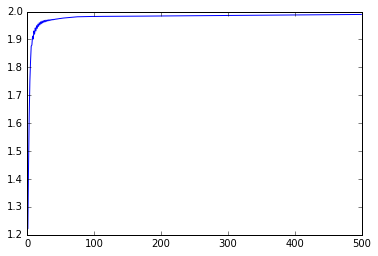

In [13]:
c = 0

for lr1 in [.1, 1., 10.]:
    for lr2 in [1e-1, 1e-2, 1e-3]:
        for n in [1e3, 1e4, 1e5]:
            
            
            c += 1
        
            T, scores = aligner.optimize(type='affine', max_iter_num=500, history_len=500, terminate_thresh=1e-4,
            #                              indices_m=[name_to_label_fixed['SNR_L']],
                                         indices_m=None,
                                        grid_search_iteration_number=10,
                                         grid_search_sample_number=100,
                                         grad_computation_sample_number=n,
                                         lr1=lr1, lr2=lr2)
            #                              init_T=[1,0,0,-10,0,1,0,0,0,0,1,0])
            
            plt.figure();
            plt.plot(scores);
            plt.savefig(atlasAlignParams_dir + '/affine/%(stack_moving)s_to_%(stack_fixed)s_scoreEvolution_%(c)d.png' % \
                        {'stack_moving': stack_moving, 'stack_fixed': stack_fixed, 'c':c},
                        bbox_inches='tight')
            
            with open(atlasAlignParams_dir + '/affine/%(stack_moving)s_to_%(stack_fixed)s_scoreEvolution_%(c)d.txt' % \
                       {'stack_moving': stack_moving, 'stack_fixed': stack_fixed, 'c':c}, 'w') as f:
                f.write(array_to_one_liner([lr1, lr2, n]))
#             print max(scores), scores[-1]

In [13]:
c = 0
for lr1 in [.1, 1., 10.]:
    for lr2 in [1e-1, 1e-2, 1e-3]:
        for n in [1e3, 1e4, 1e5]:
            c += 1
            print c, lr1, lr2, int(n)

1 0.1 0.1 1000
2 0.1 0.1 10000
3 0.1 0.1 100000
4 0.1 0.01 1000
5 0.1 0.01 10000
6 0.1 0.01 100000
7 0.1 0.001 1000
8 0.1 0.001 10000
9 0.1 0.001 100000
10 1.0 0.1 1000
11 1.0 0.1 10000
12 1.0 0.1 100000
13 1.0 0.01 1000
14 1.0 0.01 10000
15 1.0 0.01 100000
16 1.0 0.001 1000
17 1.0 0.001 10000
18 1.0 0.001 100000
19 10.0 0.1 1000
20 10.0 0.1 10000
21 10.0 0.1 100000
22 10.0 0.01 1000
23 10.0 0.01 10000
24 10.0 0.01 100000
25 10.0 0.001 1000
26 10.0 0.001 10000
27 10.0 0.001 100000


In [ ]:
# READ

In [ ]:
stack_fixed = 'MD589'
stack_moving = 'MD594'

In [ ]:
atlasAlignParams_dir = create_if_not_exists(atlasAlignParams_rootdir + '/%(stack_moving)s_to_%(stack_fixed)s' % \
                     {'stack_moving': stack_moving, 'stack_fixed': stack_fixed})

In [ ]:
volume_fixed = bp.unpack_ndarray_file(os.path.join(volume_dir, '%(stack)s/%(stack)s_down32_annotationVolume.bp' % {'stack': stack_fixed}))
volume_moving = bp.unpack_ndarray_file(os.path.join(volume_dir, '%(stack)s/%(stack)s_down32_annotationVolume.bp' % {'stack': stack_moving}))
print volume_fixed.shape
print volume_moving.shape

In [ ]:
# stack = 'MD589'

with open(atlasAlignParams_dir + '/%(stack_moving)s_down32_annotationVolume_to_%(stack_fixed)s_down32_annotationVolume_parameters.txt' % \
          {'stack_moving': stack_moving, 'stack_fixed': stack_fixed}, 'r') as f:
    
    lines = f.readlines()
    
    global_params = one_liner_to_arr(lines[0], float)
    centroid_m = one_liner_to_arr(lines[1], float)
    xdim_m, ydim_m, zdim_m  = one_liner_to_arr(lines[2], int)
    centroid_f = one_liner_to_arr(lines[3], float)
    xdim_f, ydim_f, zdim_f  = one_liner_to_arr(lines[4], int)

In [ ]:
all_indices_m = set(np.unique(volume_moving)) - {0}

In [ ]:
nzvoxels_m = {i: parallel_where_binary(volume_moving==i) for i in all_indices_m}

In [ ]:
# HANGS for some reason
# from multiprocessing import Pool

# pool = Pool(2)
# # nzvoxels_m_ = pool.map(lambda i: parallel_where_binary(volume_m[i] > 0, num_samples=int(1e6)),
# #                         self.all_indices_m)
# nzvoxels_m = pool.map(lambda i: parallel_where_binary(volume_moving==i),
#                         all_indices_m)
# pool.close()
# pool.join()

# nzvoxels_m = dict(zip(all_indices_m, nzvoxels_m))

In [ ]:
from registration_utilities import transform_points

In [ ]:
nzs_m_aligned_to_f = {ind_m: transform_points(global_params, pts=nzs_m, 
                                              c=centroid_m, c_prime=centroid_f).astype(np.int16)
                      for ind_m, nzs_m in nzvoxels_m.iteritems()}

volume_m_aligned_to_f = np.zeros((ydim_f, xdim_f, zdim_f), np.int)

for ind_m in nzs_m_aligned_to_f.iterkeys():

    xs_f, ys_f, zs_f = nzs_m_aligned_to_f[ind_m].T
    
    valid = (xs_f >= 0) & (ys_f >= 0) & (zs_f >= 0) & \
    (xs_f < xdim_f) & (ys_f < ydim_f) & (zs_f < zdim_f)

    xs_m, ys_m, zs_m = nzvoxels_m[ind_m].T
    
    volume_m_aligned_to_f[ys_f[valid], xs_f[valid], zs_f[valid]] = \
    volume_moving[ys_m[valid], xs_m[valid], zs_m[valid]]

del nzs_m_aligned_to_f

In [ ]:
filename_to_section = {}
section_to_filename = {}
with open('/home/yuncong/CSHL_data_processed/%(stack_fixed)s/%(stack_fixed)s_sorted_filenames.txt' %\
          dict(stack_fixed=stack_fixed), 'r') as f:
    for line in f.readlines():
        fn, label = line.strip().split()
        filename_to_section[fn] = int(label)
        section_to_filename[int(label)] = fn

In [ ]:
with open('/home/yuncong/csd395/CSHL_volumes2/%(stack_fixed)s/%(stack_fixed)s_down32_annotationVolume_bbox.txt' %\
          dict(stack_fixed=stack_fixed), 'r') as f:
    xmin_vol_f, xmax_vol_f, ymin_vol_f, ymax_vol_f, zmin_vol_f, zmax_vol_f = map(int, f.readline().strip().split())
    print xmin_vol_f, xmax_vol_f, ymin_vol_f, ymax_vol_f, zmin_vol_f, zmax_vol_f

In [ ]:
# with open('/home/yuncong/CSHL_data_processed/%(stack_fixed)s/%(stack_fixed)s_cropbox.txt' %\
#           dict(stack_fixed=stack_fixed), 'r') as f:
#     xmin, xmax, ymin, ymax, sec_min, sec_max = map(int, f.readline().strip().split())
#     print xmin, xmax, ymin, ymax, sec_min, sec_max

In [ ]:
# volume_tb_fixed = bp.unpack_ndarray_file('/home/yuncong/csd395/CSHL_volumes2/%(stack_fixed)s/%(stack_fixed)s_down32Volume.bp' % dict(stack_fixed=stack_fixed))

In [ ]:
from registration_utilities import find_contour_points

In [ ]:
downsample_factor = 32
xy_pixel_distance_downsampled = xy_pixel_distance_lossless * downsample_factor
voxel_z_size = section_thickness / xy_pixel_distance_downsampled

In [ ]:
create_if_not_exists(os.path.join(atlasAlignParams_dir, 'viz'))

In [ ]:
bar = show_progress_bar(100, 300)

for sec in range(100, 300):
    
    if section_to_filename[sec] in ['Placeholder', 'Rescan', 'Nonexisting']:
        continue
    
    bar.value = sec

    z = voxel_z_size * (sec - 1) - zmin_vol_f

    contours_f_on_volume = find_contour_points(volume_fixed[..., int(z)])
    contours_f_on_cropped = {i: [cnt + (xmin_vol_f, ymin_vol_f) for cnt in cnts] for i, cnts in contours_f_on_volume.iteritems()}

    contours_m_alignedTo_f_on_volume = find_contour_points(volume_m_aligned_to_f[..., int(z)])
    contours_m_alignedTo_f_on_cropped = {i: [cnt + (xmin_vol_f, ymin_vol_f) for cnt in cnts] for i, cnts in contours_m_alignedTo_f_on_volume.iteritems()}

    img = imread('/home/yuncong/CSHL_data_processed/%(stack_fixed)s/%(stack_fixed)s_thumbnail_sorted_aligned/%(stack_fixed)s_%(sec)04d_thumbnail_aligned.tif' %\
               dict(stack_fixed=stack_fixed, sec=sec))


    viz = img.copy()

    for ind_m, cnts_m in contours_m_alignedTo_f_on_cropped.iteritems():
        for cnt_m in cnts_m:
            cv2.polylines(viz, [cnt_m.astype(np.int)], True, (255,0,0), 2)

    for ind_f, cnts_f in contours_f_on_cropped.iteritems():
        for cnt_f in cnts_f:
            cv2.polylines(viz, [cnt_f.astype(np.int)], True, (0,255,0), 2)


#     plt.figure(figsize=(20,20));
#     plt.imshow(viz[:800, :1200])
#     plt.show();
    
    viz_fn = os.path.join(atlasAlignParams_dir, 'viz', '%(stack_moving)s_to_%(stack_fixed)s_%(sec)04d.jpg' % \
          {'stack_moving': stack_moving, 'stack_fixed': stack_fixed, 'sec': sec})
    imsave(viz_fn, viz[:800, :1200])

In [ ]:
volume_m_alignedTo_f_fn = os.path.join(atlasAlignParams_dir, '%(stack_moving)s_down32_annotationVolume_alignedTo_%(stack_fixed)s_down32_annotationVolume.bp' % \
                                       {'stack_moving': stack_moving, 'stack_fixed': stack_fixed})

In [ ]:
from annotation_utilities import fill_sparse_volume
volume_m_aligned_to_f_densified = fill_sparse_volume(volume_m_aligned_to_f)

In [ ]:
bp.pack_ndarray_file(volume_m_aligned_to_f_densified, volume_m_alignedTo_f_fn)